In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *

In [9]:
# machine performance
P_fus = 500
Q = 10
# plasma geometry
lam = 4.94
kappa = 1.7
eps = 0.3226
delta = 0.33
# plasma parameters
q_a = 3
y_rad = 0.7
n_N = 0.85

# coefficients (fixed)
C_I = 13.144
C_beta = 0.726
C_fus = 1.38e-3
C_loss = 0.086
C_SL = 0.0562
C_n = 3.183
M = 2.55

def rhs_fus(beta_N):
    rhs = P_fus / (C_fus * C_I**2 / C_beta**2 * kappa * eps**4 / q_a**2 * beta_N**2)
    return rhs

def rhs_bal(beta_N):
    rhs =    (C_loss / y_rad / C_fus * Q / (1 + Q/lam) )**0.31 \
           / (C_SL * C_n**0.41 * C_I**0.96 * C_beta**0.38 * C_loss**(-0.69) * M**0.19
              * kappa**0.09 * eps**0.68 * q_a**(-0.96) * n_N**0.41 * beta_N**(-0.38) )
    return rhs

def R_fus(B, beta_N):
    return (rhs_fus(beta_N) / B**4 )**(1/3)

def B_bal(R, beta_N):
    return (rhs_bal * R**(-0.42) )**(1/0.73)

def R_sol(beta_N):
    a1 = rhs_fus(beta_N)
    a2 = rhs_bal(beta_N)
    return (a1 / a2**(4/0.73) )**1.43

def B_sol(beta_N):
    a2 = rhs_bal(beta_N)
    return (a2 * R_sol(beta_N)**(-0.42) )**(1/0.73)

We choose $\beta_N=1.695$ and obtain the associated couple ($R_0,B_0$)

In [10]:
beta_N = 1.695
B0 = B_sol(beta_N)
R0 = R_sol(beta_N)
print(R0, B0)

5.993341439520774 5.4349344860973705


What is the outer position of the TF coil? We take $\Delta_{int}=1.23\,$m as the distance between the LCFS and the the TF coil. We then have simply:
$$
R_e = R_0 - a - \Delta_{int}, \quad \text{with} \,\, a = \epsilon R_0
$$

In [11]:
a = eps * R0
Delta_int = 1.23
R_e = R0 - a - Delta_int
R_e

2.829889491131372

In [12]:
B_e = B0 * R0 / R_e
B_e

11.510491197161645

We could also plot the curve as function of $\beta_N$.

In [13]:
def B_at_TF_coil(beta_N):
    R_e = R_sol(beta_N) * (1 - eps) - Delta_int
    return B_sol(beta_N) * R_sol(beta_N) / R_e
B_tmax = B_at_TF_coil(beta_N)
B_tmax

11.510491197161645

Text(432.62626262626253, 0.5, 'applied field $B_\\mathrm{TF}$ [T]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
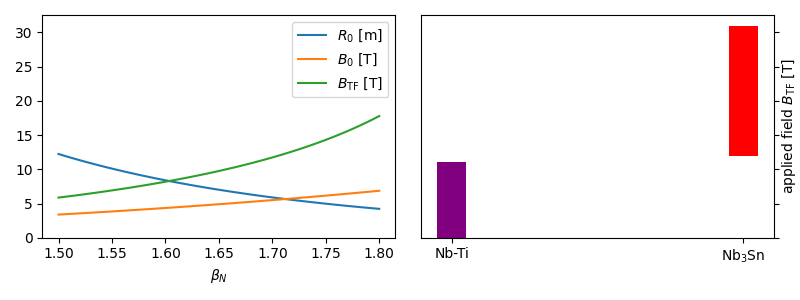

In [17]:

fig, [ax, ax2] = plt.subplots(1,2, sharey=True, figsize=(8,3))

Beta_N = np.linspace(1.5,1.8,50)
ax.plot(Beta_N, R_sol(Beta_N), label='$R_0$ [m]')
ax.plot(Beta_N, B_sol(Beta_N), label='$B_0$ [T]')
ax.plot(Beta_N, B_at_TF_coil(Beta_N), label='$B_{\mathrm{TF}}$ [T]')

ax.set_xlabel(r'$\beta_N$')
ax.legend()
plt.tight_layout()

width = 0.1
dsep = 0.2


materials = ['Nb-Ti', 'Nb$_3$Sn']
B_min = [0, 12]
B_max = [11, 19]
cols = ['purple', 'red']
nmat = len(materials)

X = np.arange(nmat)

for i in range(len(materials)):
    rect, = ax2.bar(X[i], B_max[i], width, bottom=B_min[i], color=cols[i])
    #autolabel(ax2, rect, materials[i], bottom=B_min[i])


ax2.set_xticks(X)
ax2.set_xticklabels(materials)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel('applied field $B_\mathrm{TF}$ [T]')

### Current
$$\mu_0 (N I)_\mathrm{tot} = 2 \pi R B$$

### Ripple ###
Ripple = $\left( \frac{R_0 + a}{r_2} \right)^{N_\mathrm{TF}}$
Should stay below $1\%$. The outer distance between two TF coils should be $d_\text{TFC}=3.5\,$T.

In [18]:
def ripple(N_TF, R0, eps, d_TFC):
    return (R0 * (1 + eps) / (N_TF * d_TFC / 2 / pi) )**N_TF
def get_N_TF(R0, eps, d_TFC, max_ripple=0.01):
    _NTF = np.arange(1,50)
    Ripple = ripple(_NTF, R0, eps, d_TFC)
    return _NTF[Ripple < 0.01].min()
def get_R2(N_TF, d_TFC):
    return N_TF * d_TFC / 2 / pi

d_TFC = 3.5
N_TF = get_N_TF(R0, eps, d_TFC)
R2 = get_R2(N_TF, d_TFC)
print(N_TF, R2)

19 10.58380371561104


### D-shape
\begin{align}
R &= R_0 + a \, \cos (\theta - \delta \, \sin (\theta )) \\
Z &= \kappa a \, \sin (\theta)
\end{align}


In [19]:
from scipy.integrate import quad
from scipy.special import iv
from numpy import sin, cos, tan, exp, log

7.893088357257397


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
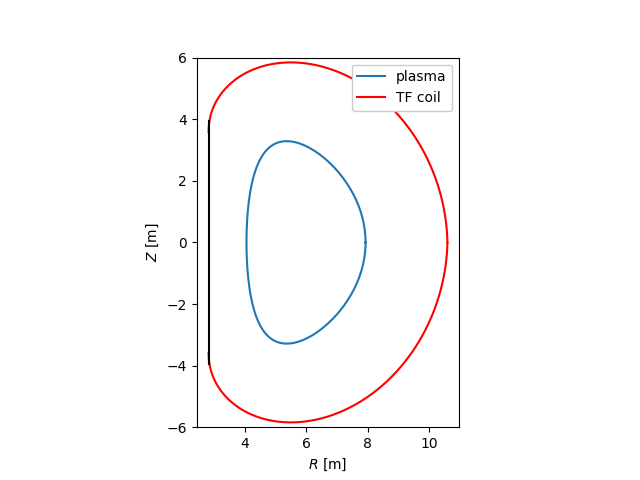

In [24]:
def RZ_plasma(th, R0, delta, kappa):
    R = R0 + a * np.cos(th + delta * np.sin(th))
    Z = kappa * a * np.sin(th)
    return R, Z

def RZ_coil(th, R_e, R2, R1):
    k = 1/2 * np.log(R2/R1)
    r0 = np.sqrt(R_e  * R2)
    haa = 2 * pi * r0 * k * iv(1,k)

    print(haa)
    
    R = r0 * np.exp(k * np.sin(th))
    R[R < R_e] = R_e
    
    ith = (R > R_e)
    #mith = (R > R_e) & (th < 3 * pi/2)
    
    #ith = (pi/2 <= th) & (th < 3 * pi/2)

    dZ = np.diff(R) * np.tan(th[1:])
    Z = np.zeros_like(R)
    Z[1:] = np.cumsum(dZ)
    
    #Z[(R > R_e)] = (R - r0) * tan(th)
    #Z[R > R_e & th > pi] = -Z_upper
    #Z[R==0] = 0
    return R, Z, haa
    
Theta = np.linspace(0, 2 * pi, 200, endpoint=True)
R_plasma, Z_plasma = RZ_plasma(Theta, R0, delta, kappa)

Theta = np.linspace(pi/2, 3 *pi/2-1e-2, 200, endpoint=True)
R_coil, Z_coil, haa = RZ_coil(Theta, R_e, R2, R_e)

fig, ax = plt.subplots()
ax.plot(R_plasma, Z_plasma, label='plasma')

ax.plot(R_coil, Z_coil, color='red', label='TF coil')
ax.plot(R_coil, -Z_coil, color='red')
ax.plot(np.array([R_e, R_e]), np.array([-haa/2, haa/2]), color='black')

ax.set_aspect('equal')
ax.set_xlabel('$R$ [m]')
ax.set_ylabel('$Z$ [m]')
ax.set_ylim(-6, 6)

ax.legend(loc='upper right', framealpha=1)

### Current density in the cable

Using the assumptions listed on sl. 26:

$$ I_c\,[\text{A}] = -20.427 \cdot B \, [\text{T}] + 308.3 $$

Also, $A_\text{Cu} = A_\text{Sc}$ and $A_\text{void} = 0.3 \, (A_\text{Cu} + A_\text{Sc})$, where $A_\text{cable} = A_\text{Cu} + A_\text{Sc} + A_\text{void} + A_\text{inner}$ stands for the cros-sectional area of the cable. What is the current density then?

In [54]:
I_cable = 68e3 # A

# number of windings per coil (using previously found Ampere Law and number of coils):
def N_wind(B_tmax, R_e, N_TF):
    return 2 * pi / mu_0 * B_tmax * R_e / N_TF / I_cable

def I_c(B):
    return -20.427 * B + 308.3

def A_inner():
    return pi * (0.01/2)**2

def A_cable(A_sc):
    return 2.6 * A_sc + A_inner()

def L_coil(N_wind, R2, R1, R_e):
    """ Coil inductance """
    k = 1/2 * np.log(R2/R1)
    r0 = np.sqrt(R_e  * R2)
    return mu_0 * r0 * N_wind**2 * k**2 / 2 * (iv(0,k) + 2 * iv(1,k) + iv(2,k))

r_strand = 0.4e-3 # m
A_strand = pi * r_strand**2
A_sc     = A_strand * I_cable / I_c(B_tmax)
j_sc     = I_cable / A_sc
j_cable  = I_cable / A_cable(A_sc)
D_cable  = 2 * (A_cable(A_sc) / pi)**0.5
I_coil   = I_cable * N_wind(B_tmax, R_e, N_TF)
_L_coil  = L_coil(N_TF, R2, R_e, R_e)

N_wind(B_tmax, R_e, N_TF), j_cable * 1e-6, j_sc * 1e-6, A_cable(A_sc), D_cable, _L_coil, I_coil/1e6

(126.05811942289367,
 52.59031219750658,
 145.57742756680324,
 0.0012930138110726795,
 0.04057482367363358,
 0.0010066229787641257,
 8.57195212075677)

In [55]:
I_coil * N_TF / 1e6, 2*pi / mu_0 * B_tmax * R_e / 1e6

(162.8670902943786, 162.86709029437864)

### Energy in the TF system
$U_\text{coil} = \frac{1}{2} L I^2$

In [52]:
U_coil = 0.5 * _L_coil * I_coil**2
print(U_coil * N_TF / 1e9, 'GJ')

702.6675835941243 GJ


### CS magnetic field ###
For a long solenoid of length $l$, we have $B\approx \mu_0 N I / l$.